# Label Prediction

This notebook contains:
- BERT and T5 refined to Label Prediction;

In [ ]:
pip install nltk protobuf==3.20.* -q

In [ ]:
import nltk
nltk.download('punkt')

In [ ]:
!pip install -r pygaggle/requirements.txt -q

### Imports and Global Variables

In [24]:
import os
import copy
import torch
import random
import json
import jsonlines
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

from nltk import tokenize
from torch.optim import Adam
from tqdm.notebook import tqdm
from rank_bm25 import BM25Okapi
from torch.utils.data import Dataset, DataLoader
from pyserini.search.lucene import LuceneSearcher
from sklearn.metrics import recall_score, accuracy_score, precision_score, classification_report, f1_score
from transformers import BertTokenizerFast, BertForSequenceClassification, T5Tokenizer, T5ForConditionalGeneration

In [2]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

os.environ["TOKENIZERS_PARALLELISM"] = "false"

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda:1


In [4]:
params = {
    'batch_size': 8,
    'optimizer': 'Adam',
    'learning_rate': 1e-5,
    'epochs': 1,
    'version': 'base',
    'model': 'bert',
    'early_stopping': None,
    'seed': 42,
    'max_length': 512,
    'evaluate_interval': 100,
    'accumulate_grad_batches': 8
}

### Read Json

In [5]:
def read_json(path):
    docs = []
    with jsonlines.open(path) as file:
        for line in file.iter():
            docs.append(line)
            
    return docs

corpus = read_json('data/corpus.jsonl')
train_json = read_json('data/claims_train.jsonl')
valid_json = read_json('data/claims_dev.jsonl')
test_json  = read_json('data/claims_test.jsonl')

### Pyserini

In [6]:
def pyserini_search(claim, top_k, return_hits=False):
    docs = []
    searcher = LuceneSearcher('scifact_index')
    hits = searcher.search(claim, k=top_k)

    for i in range(len(hits)):
        docs.append(json.loads(hits[i].raw))
     
    if return_hits: return hits
    
    return docs

### BERT

#### Dataset

In [26]:
def prepare_dataset_sentence(data):
    dataset = {'inputs': [], 'labels': []}

    # SUPPORT AND REFUTES - 0 - 1
    for sample in train_json:
        claim    = sample['claim']
        evidence = sample['evidence']
        if not evidence: continue

        for _id_ in evidence.keys():
            for doc in corpus:
                doc_id = str(doc['doc_id'])
                if doc_id == _id_:
                    sentences = evidence[_id_]
                    abstract  = doc['abstract']

                    idxs  = []
                    for s in sentences:
                        for i in s['sentences']:
                            idxs.append(i)
                            label = 1 if s['label'] == 'SUPPORT' else 0

                    hypothesis = f'hypothesis: {claim} '
                    for i, idx in enumerate(idxs):
                        hypothesis += f'sentence{i}: {abstract[idx]} '
                    
                    #for _ in range(0, 10):
                    dataset['inputs'].append(hypothesis)
                    dataset['labels'].append(label)
                    
    ## NoInfo - 2
    for sample in train_json:
        claim    = sample['claim']
        evidence = sample['evidence']
        if not evidence: continue

        docs = pyserini_search(claim, top_k=5)

        for doc in docs:
            doc_id = str(doc['id'])
            if doc_id not in list(evidence.keys()):
                abstract = tokenize.sent_tokenize(doc['contents'])
                random_sentences = random.randint(1,2)
                random_idx = random.sample(range(0, len(abstract)), random_sentences)

                hypothesis = f'hypothesis: {claim} '
                for i, idx in enumerate(random_idx):
                    hypothesis += f'sentence{i}: {abstract[idx]} '

                dataset['inputs'].append(hypothesis)
                dataset['labels'].append(2)
    
    return dataset

In [27]:
class SentenceDataset(Dataset):
    def __init__(self, dataset, labels):
        self.encodings = dataset
        self.labels    = torch.Tensor(labels).long()
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        item = {key: value[index] for key, value in self.encodings.items()}
        item['labels'] = self.labels[index] 
        return item

In [28]:
tokenizer = BertTokenizerFast.from_pretrained('bert-large-cased', disable_tqdm=False)

# Sentence Split
train_sentence = prepare_dataset_sentence(train_json)
valid_sentence = prepare_dataset_sentence(valid_json)

# Tokenizer
train_encoding = tokenizer(train_sentence['inputs'], truncation=True, padding=True, return_tensors='pt', max_length=params['max_length'])
valid_encoding = tokenizer(valid_sentence['inputs'], truncation=True, padding=True, return_tensors='pt', max_length=params['max_length'])

# Dataset
train_dataset = SentenceDataset(train_encoding, train_sentence['labels'])
valid_dataset = SentenceDataset(valid_encoding, valid_sentence['labels'])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=params['batch_size'], shuffle=True)

#### Train Step

In [7]:
class EarlyStopping():
    def __init__(self, patience=3, min_delta=0.0001):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.best_model_wts = None
        self.min_delta = min_delta

    def __call__(self, model, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_wts = copy.deepcopy(model.state_dict())
            return False

        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.best_score = score
            self.best_model_wts = copy.deepcopy(model.state_dict())
            self.counter = 0
        return False

In [21]:
def train_step(model, data, optimizer, batch_idx, accumulate_grad_batches, dataloader_size):
    model.train()
    
    input_ids      = data['input_ids'].to(device)
    attention_mask = data['attention_mask'].to(device)
    labels         = data['labels'].to(device)
    
    optimizer.zero_grad()
    
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs[0]
    loss.backward()
    
    _, preds = torch.max(outputs[1], 1)    

    if ((batch_idx + 1) % accumulate_grad_batches == 0) or (batch_idx + 1 == dataloader_size):
        optimizer.step()
        optimizer.zero_grad()
        
    return loss.item(), labels, preds

def evaluate(model, dataloader):
    running_loss = 0.0
    #running_corrects = 0

    model.eval()
    for data in dataloader:
        
        input_ids      = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels         = data['labels'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            _, preds = torch.max(outputs[1], 1)

            running_loss += loss.item()
            #running_corrects += torch.sum(preds == labels)

    return running_loss/len(dataloader)

In [24]:
model = BertForSequenceClassification.from_pretrained('bert-large-cased', num_labels=3)
model = model.to(device)

optimizer = Adam(model.parameters(), lr=params['learning_rate'])
train_history = {'loss': [], 'recall': [], 'precision': [], 'accuracy': []}
valid_history = {'loss': []}
early_stopping = EarlyStopping()

epoch = 1
while True:
    for batch_idx, data in enumerate(tqdm(train_loader, total=len(train_loader), desc=f'Training Epoch {epoch}')):
        train_loss, labels, preds = train_step(model=model, 
                                data=data, 
                                optimizer=optimizer,
                                batch_idx=batch_idx, 
                                accumulate_grad_batches=params['accumulate_grad_batches'], 
                                dataloader_size=len(train_loader))
        
        recall    = recall_score(labels.cpu().numpy(), preds.cpu().numpy(), zero_division=0, average='micro')
        precision = precision_score(labels.cpu().numpy(), preds.cpu().numpy(), zero_division=0, average='micro')
        accuracy  = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
    
        train_history['loss'].append(train_loss)
        train_history['recall'].append(recall)
        train_history['precision'].append(precision)
        train_history['accuracy'].append(accuracy)
        
        if ((batch_idx + 1) % params['evaluate_interval'] == 0):
            val_loss = evaluate(model=model,
                                dataloader=valid_loader)
        
            valid_history['loss'].append(val_loss)
            
            if early_stopping(model=model, val_loss=val_loss): break
            
    epoch += 1
    if early_stopping(model=model, val_loss=val_loss): break

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Training Epoch 1:   0%|          | 0/480 [00:00<?, ?it/s]

Training Epoch 2:   0%|          | 0/480 [00:00<?, ?it/s]

Training Epoch 3:   0%|          | 0/480 [00:00<?, ?it/s]

Training Epoch 4:   0%|          | 0/480 [00:00<?, ?it/s]

Training Epoch 5:   0%|          | 0/480 [00:00<?, ?it/s]

Training Epoch 6:   0%|          | 0/480 [00:00<?, ?it/s]

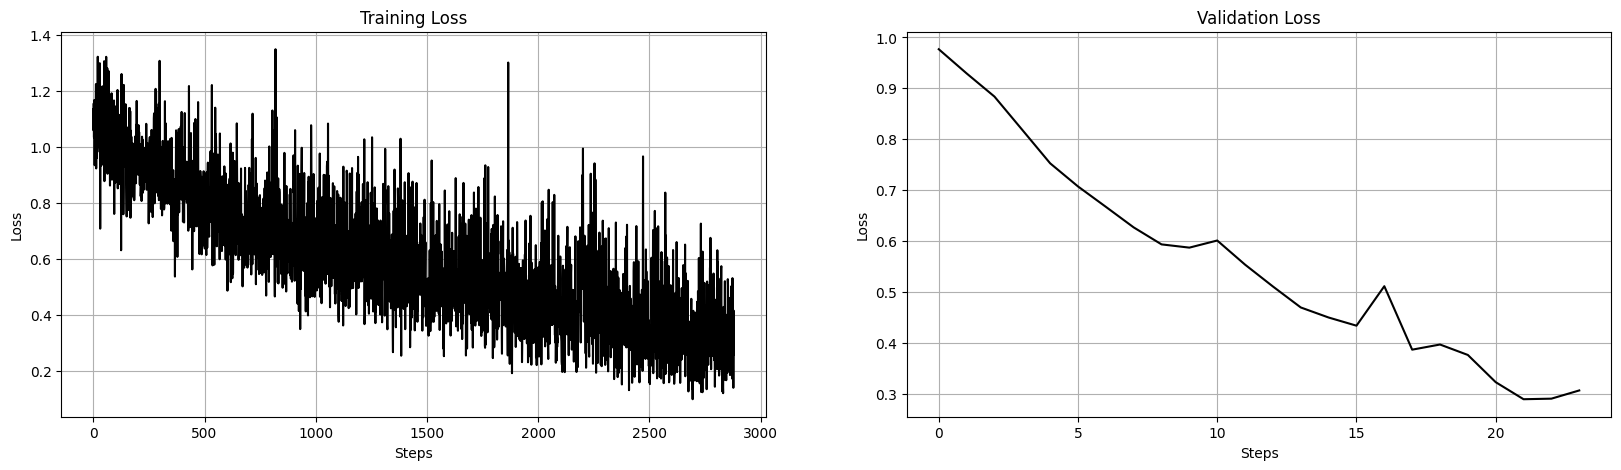

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(train_history['loss'], '-k')
ax[0].grid()
ax[0].set_xlabel('Steps')
ax[0].set_title('Training Loss')
ax[0].set_ylabel('Loss')

ax[1].plot(valid_history['loss'], '-k')
ax[1].grid()
ax[1].set_xlabel('Steps')
ax[1].set_title('Validation Loss')
ax[1].set_ylabel('Loss')

plt.show()

In [7]:
all_preds  = []
all_labels = []
running_loss = 0.0

model.eval()
for data in tqdm(valid_loader, total=len(valid_loader), desc='Validating Model'):

    input_ids      = data['input_ids'].to(device)
    attention_mask = data['attention_mask'].to(device)
    labels         = data['labels'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        _, preds = torch.max(outputs[1], 1)
        
        for i, j in zip(preds.cpu().numpy(), labels.cpu().numpy()):
            all_preds.append(i)
            all_labels.append(j)
            
        running_loss += loss.item()

torch.save(model.state_dict(), 'bert_label_prediction.pth')
print(classification_report(all_labels, all_preds, target_names=['Supports', 'Refutes', 'NoInfo']))

              precision    recall  f1-score   support

    Supports       0.80      0.75      0.77       194
     Refutes       0.67      0.77      0.71       370
      NoInfo       0.76      0.81      0.78      2035

    accuracy                           0.75      2599
   macro avg       0.74      0.77      0.75      2599
weighted avg       0.75      0.79      0.78      2599



### monoT5

#### Dataset

In [16]:
def prepare_dataset_sentence(data):
    dataset = {'inputs': [], 'labels': []}

    # SUPPORT AND REFUTES - 0 - 1
    for sample in train_json:
        claim    = sample['claim']
        evidence = sample['evidence']
        if not evidence: continue

        for _id_ in evidence.keys():
            for doc in corpus:
                doc_id = str(doc['doc_id'])
                if doc_id == _id_:
                    sentences = evidence[_id_]
                    abstract  = doc['abstract']

                    idxs  = []
                    for s in sentences:
                        for i in s['sentences']:
                            idxs.append(i)
                            label = 'true' if s['label'] == 'SUPPORT' else 'false'

                    hypothesis = f'hypothesis: {claim} '
                    for i, idx in enumerate(idxs):
                        hypothesis += f'sentence{i}: {abstract[idx]} '
                    
                    #for _ in range(0, 10):
                    dataset['inputs'].append(hypothesis)
                    dataset['labels'].append(label)
                    
    ## NoInfo - 2
    for sample in train_json:
        claim    = sample['claim']
        evidence = sample['evidence']
        if not evidence: continue

        docs = pyserini_search(claim, top_k=5)

        for doc in docs:
            doc_id = str(doc['id'])
            if doc_id not in list(evidence.keys()):
                abstract = tokenize.sent_tokenize(doc['contents'])
                random_sentences = random.randint(1,2)
                random_idx = random.sample(range(0, len(abstract)), random_sentences)

                hypothesis = f'hypothesis: {claim} '
                for i, idx in enumerate(random_idx):
                    hypothesis += f'sentence{i}: {abstract[idx]} '

                dataset['inputs'].append(hypothesis)
                dataset['labels'].append('weak')
    
    return dataset

In [17]:
class SentenceDataset(Dataset):
    def __init__(self, dataset, labels):
        self.encodings = dataset
        self.labels    = labels
        
    def __len__(self):
        return len(self.labels['input_ids'])
    
    def __getitem__(self, index):
        item  = {key: value[index] for key, value in self.encodings.items()}
        label = {key: value[index] for key, value in self.labels.items()}
        return item, label

In [18]:
train_sentence = prepare_dataset_sentence(train_json)
valid_sentence = prepare_dataset_sentence(valid_json)

In [19]:
tokenizer = T5Tokenizer.from_pretrained('t5-large')

# Sentence Split
train_sentence = prepare_dataset_sentence(train_json)
valid_sentence = prepare_dataset_sentence(valid_json)

# Tokenizer
train_encoding = tokenizer(train_sentence['inputs'], truncation=True, padding=True, return_tensors='pt', max_length=params['max_length'])
train_labels   = tokenizer(train_sentence['labels'], truncation=True, padding=True, return_tensors='pt', max_length=5)

valid_encoding = tokenizer(valid_sentence['inputs'], truncation=True, padding=True, return_tensors='pt', max_length=params['max_length'])
valid_labels   = tokenizer(valid_sentence['labels'], truncation=True, padding=True, return_tensors='pt', max_length=5)

# Dataset
train_dataset = SentenceDataset(train_encoding, train_labels)
valid_dataset = SentenceDataset(valid_encoding, valid_labels)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=params['batch_size'], shuffle=True)

In [12]:
def train_step(model, data, label, optimizer, batch_idx, accumulate_grad_batches, dataloader_size):
    model.train()
    
    input_ids      = data['input_ids'].to(device)
    attention_mask = data['attention_mask'].to(device)
    labels         = label['input_ids'].to(device)
    
    optimizer.zero_grad()
    
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs[0]
    loss.backward()
    
    _, preds = torch.max(outputs[1], 1)    

    if ((batch_idx + 1) % accumulate_grad_batches == 0) or (batch_idx + 1 == dataloader_size):
        optimizer.step()
        optimizer.zero_grad()
        
    return loss.item(), labels, preds

def evaluate(model, dataloader):
    running_loss = 0.0
    #running_corrects = 0

    model.eval()
    for (data, label) in dataloader:
        
        input_ids      = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels         = label['input_ids'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            _, preds = torch.max(outputs[1], 1)

            running_loss += loss.item()
            #running_corrects += torch.sum(preds == labels)

    return running_loss/len(dataloader)

In [13]:
model = T5ForConditionalGeneration.from_pretrained('t5-large')
model = model.to(device)

optimizer = Adam(model.parameters(), lr=params['learning_rate'])
train_history = {'loss': []}
valid_history = {'loss': []}
early_stopping = EarlyStopping()

epoch = 1

while True:
    for batch_idx, (data, label) in enumerate(tqdm(train_loader, total=len(train_loader), desc=f'Training Epoch {epoch}')):
        train_loss, labels, preds = train_step(model=model, 
                                data=data,
                                label=label,
                                optimizer=optimizer,
                                batch_idx=batch_idx, 
                                accumulate_grad_batches=params['accumulate_grad_batches'], 
                                dataloader_size=len(train_loader))
        
        train_history['loss'].append(train_loss)
        
        if ((batch_idx + 1) % params['evaluate_interval'] == 0):
            val_loss = evaluate(model=model,
                                dataloader=valid_loader)
        
            valid_history['loss'].append(val_loss)
            
            if early_stopping(model=model, val_loss=val_loss): break
            
    epoch += 1
    if early_stopping(model=model, val_loss=val_loss): break

Training Epoch 1:   0%|          | 0/960 [00:00<?, ?it/s]

Training Epoch 2:   0%|          | 0/960 [00:00<?, ?it/s]

Training Epoch 3:   0%|          | 0/960 [00:00<?, ?it/s]

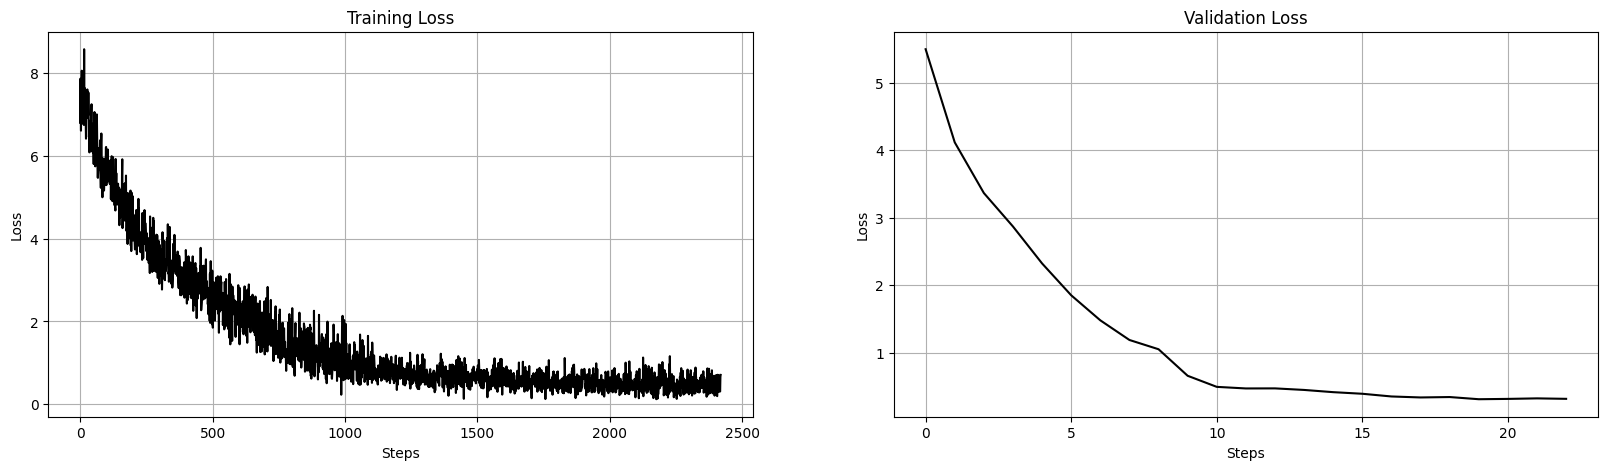

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(train_history['loss'], '-k')
ax[0].grid()
ax[0].set_xlabel('Steps')
ax[0].set_title('Training Loss')
ax[0].set_ylabel('Loss')

ax[1].plot(valid_history['loss'], '-k')
ax[1].grid()
ax[1].set_xlabel('Steps')
ax[1].set_title('Validation Loss')
ax[1].set_ylabel('Loss')

plt.show()

In [20]:
all_preds  = []
all_labels = []
running_loss = 0.0

model.eval()
for i in tqdm(range(0, len(valid_dataset))):
    (sample, label) = valid_dataset.__getitem__(i)
    
    input_ids      = sample['input_ids'].to(device)
    attention_mask = sample['attention_mask'].to(device)
    labels         = label['input_ids'].to(device)

    with torch.no_grad():
        pred = model.generate(input_ids=input_ids.reshape(1, -1), attention_mask=attention_mask.reshape(1, -1), max_length=5)[0]
        pred = tokenizer.decode(pred, skip_special_tokens=True)
        
        label = tokenizer.decode(labels, skip_special_tokens=True)
        
        if pred == 'false': all_preds.append(0)
        if pred == 'true': all_preds.append(1)
        if pred == 'weak': all_preds.append(2)
        
        if label == 'false': all_labels.append(0)
        if label == 'true': all_labels.append(1)
        if label == 'weak': all_labels.append(2)
torch.save(model.state_dict(), 'T5_label_prediction.pth')

  0%|          | 0/2599 [00:00<?, ?it/s]

In [55]:
print(classification_report(all_labels, all_preds, target_names=['Supports', 'Refutes', 'NoInfo']))

              precision    recall  f1-score   support

    Supports       0.91      0.84      0.87       194
     Refutes       0.81      0.83      0.82       370
      NoInfo       0.97      0.78      0.87      2035

    accuracy                           0.88      2599
   macro avg       0.89      0.81      0.85      2599
weighted avg       0.94      0.79      0.86      2599

